# Big Data Image Analysis

## Demo data

This tutorial will use demonstration dataset BBBC039, from the Broad Bioimage Benchmark Collection: https://bbbc.broadinstitute.org/BBBC039

Please download and unzip the data. You can download the data directly as a zip file with this link (77.9 MB): https://data.broadinstitute.org/bbbc/BBBC039/images.zip


Reference:
> BBBC039 Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection Ljosa et al., Nature Methods, 2012.
> https://bbbc.broadinstitute.org/BBBC039

## Start the Dask dashboard

This is optional, but the Dask dashboard can be an extremely useful tool when running dask computations. You can learn more about the dask dashboard with:

* This introduction to the dask dashboard (20 minute video): https://www.youtube.com/watch?v=N_GqzcuGLCY
* This introduction to the jupyterlab extension (5 minute video): https://www.youtube.com/watch?v=EX_voquHdk0


In [3]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.40 GiB
Comm: tcp://127.0.0.1:38011,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.40 GiB
Comm: tcp://127.0.0.1:38779,Total threads: 3
Dashboard: http://127.0.0.1:45671/status,Memory: 3.85 GiB
Nanny: tcp://127.0.0.1:39063,


## The dask-image library

There is a `dask-image` library available.

It contains a number of specialized image processing functions,
including image filters, fourier transforms, morphological operations,
and measurement functions.

* Documentation pages: http://image.dask.org/en/latest/
* GitHub repository: https://github.com/dask/dask-image


In [4]:
import dask_image

### The napari image viewer

`napari` is a python based image viewer.
It natively handles dask arrays, so is an excellent choice for lazily loading large image data..

* Documentation pages: https://napari.org/
* GitHub repository: https://github.com/napari/napari/

In [5]:
import napari

viewer = napari.Viewer()

It is possible to record screenshots of the current state of the napari viewer using the `nbscreenshot` function. This can be useful if you need to share your notebooks with collaborators.

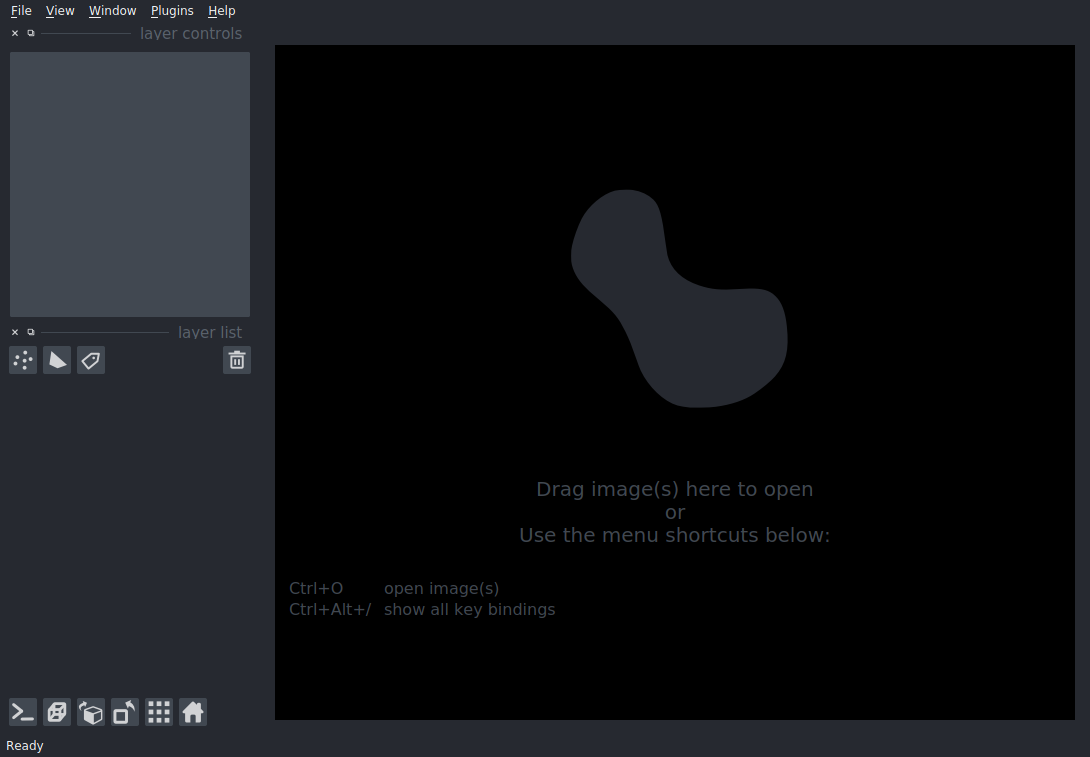

In [6]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

## Image segmentation pipeline
### Step 1. Load image data




### Exercise

Uisng the `dask-image` [imread function](http://image.dask.org/en/latest/dask_image.imread.html#dask_image.imread.imread), load all the TIFF images from our demo dataset into a single Dask array.

Explore the `shape`, `chunksize` and `chunks` attributes of the dask array. What does a single dask chunk correspond with?


In [7]:
# SOLUTION
from dask_image.imread import imread

images = imread('data/images/*.tif')
images

dask.array<_map_read_frame, shape=(200, 520, 696), dtype=uint16, chunksize=(1, 520, 696), chunktype=numpy.ndarray>

### Exercise

Display the image data in the napari image viewer. (Hint: you can check the napari documentation page here if you're stuck https://napari.org/tutorials/fundamentals/viewer.html).

Drag the napari sliders around and watch the task stream plot on the dask dashboard. What happens?

Can you adjust the contrast limits to better display the images?

In [8]:
# SOLUTION
viewer.add_image(images)
# or...
# viewer.add_image(images, contrast_limits=[0, 2000])

/home/genevieve/anaconda3/envs/napari-big-data-training/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'images' at 0x7f967f9b39d0>

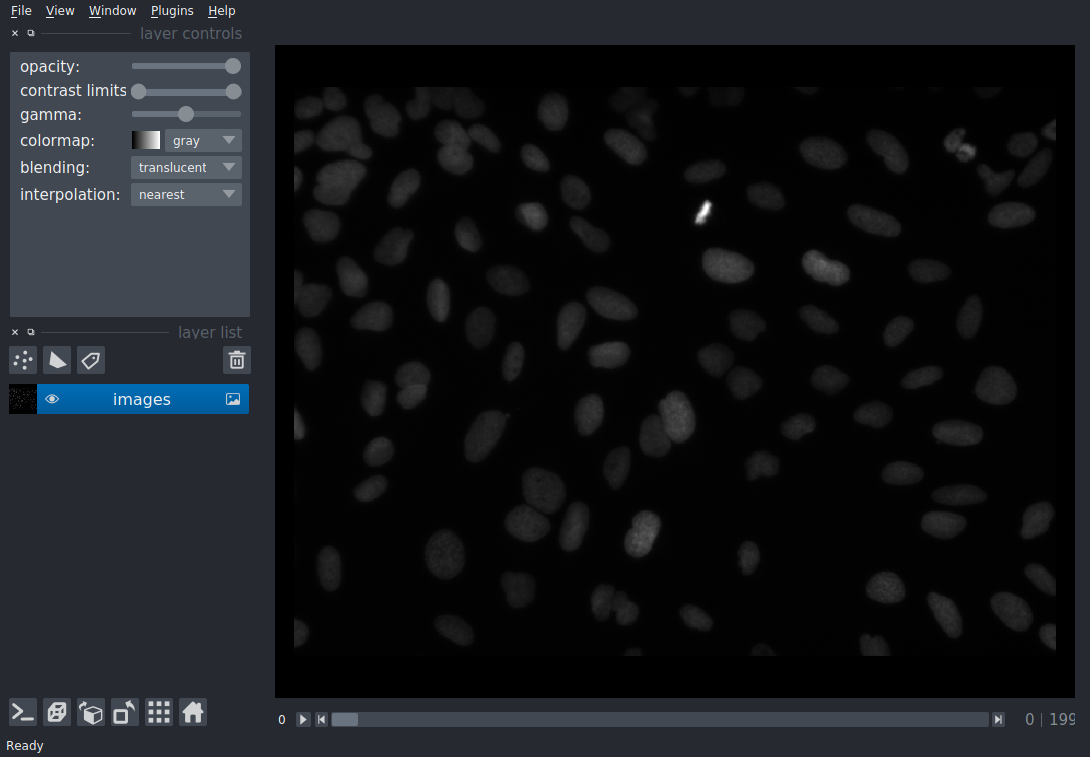

In [9]:
nbscreenshot(viewer)

### Step 2. Filtering images

Denoising images with a small blur can improve segmentation edges later in the analysis pipeline.

Here we'll use the `gaussian_filter` fucntion from `dask-image` to do this.

Note that the value we have chose for sigma will only blur data within each image frame.

In [10]:
from dask_image import ndfilters

smoothed = ndfilters.gaussian_filter(images, sigma=[0, 1, 1])

In [11]:
# Display the result in napari
viewer.add_image(smoothed)

<Image layer 'smoothed' at 0x7f967f7813a0>

### Step 3. Segmenting objects

We need to segment the cell nuclei from the background.
Demo: Poor segmentation using a single threshold value

In [12]:
absolute_threshold = smoothed > 160

In [13]:
viewer.add_image(absolute_threshold)

<Image layer 'absolute_threshold' at 0x7f967e985cd0>

### Exercise

Use local thresholding to make a better segmentation. Use a local region size equal to a single image frame.


In [14]:
# SOLUTION
from dask_image import ndfilters

thresh = ndfilters.threshold_local(smoothed, images.chunksize)
threshold_images = smoothed > thresh

viewer.add_image(threshold_images)

<Image layer 'threshold_images' at 0x7f967ea0a0d0>

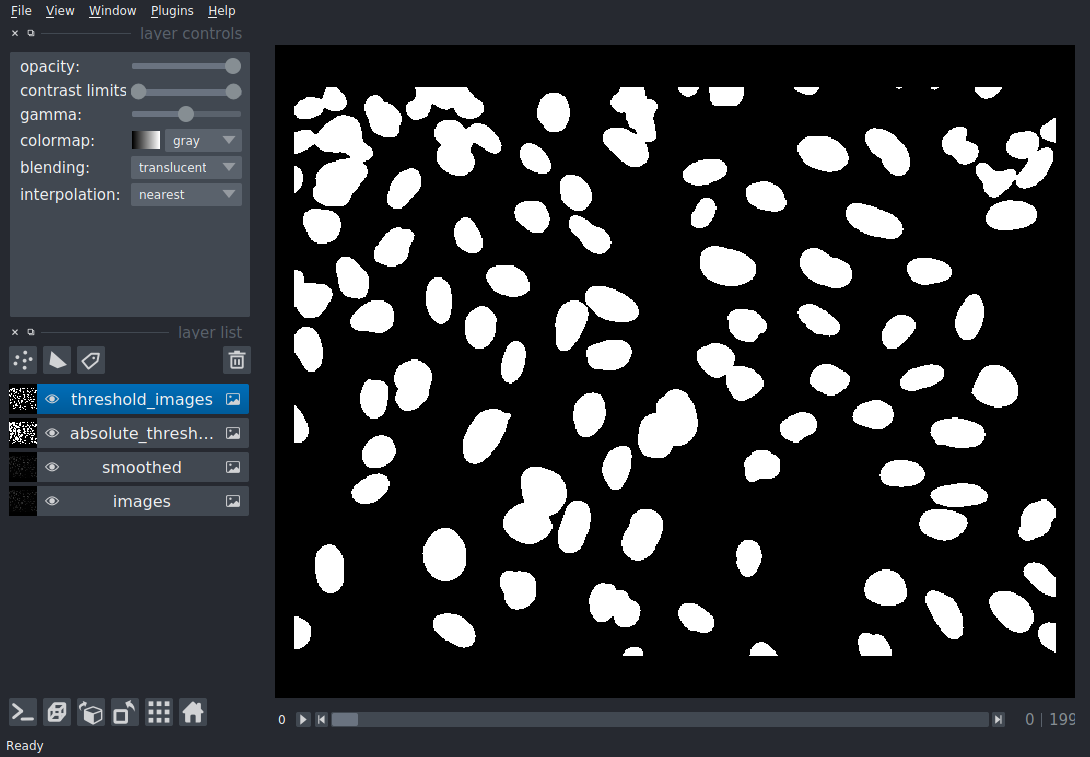

In [15]:
nbscreenshot(viewer)

### Tip

If you have many layers loaded into napari, you can improve responsiveness by toggling the visibility OFF for any layers you don't need to see.

Napari lazily loads and/or computes only the visible data if given a dask array. However, given enough layers even lazy computation can sometimes slow things down, so we can make sure to only display the layers we need to see.

### Step 4. Morphological operations

Morphological operations are operations that change the shape of a binary image.

There is an excellent detailed explanation of this [here on the OpenCV website](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html). Below are three images from the webpage, describing common morphological operations.

#### Erosion

![Erosion morphological operation](resources/erosion.png)

#### Dilation

![Dilation morphological operation](resources/dilation.png)

#### Opening
A morphological opening operation is an erosion, followed by a dilation.

![Dilation morphological operation](resources/dilation.png)

Conversely, there is also a morphological operation called "closing", which is a dilation followed by an erosion.

The opening morphological operation is particularly useful for image analysis if we look at how easily it has removed the bright specks of noise in our image backgroud, while at the same time leaving the object of interest virtually unchanged.

Let's try a morphological opening on our own data...


In [16]:
from dask_image import ndmorph
import numpy as np

structuring_element = np.array([
    [[0, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, 0]]])
binary_images = ndmorph.binary_opening(threshold_images, structure=structuring_element) 

### Step 5. Measuring objects

Finally we create a label image, then measure some properties about the objects in that image.

Each image has many individual nuclei, so for the sake of time we'll measure a small subset of the data.


In [17]:
from dask_image import ndmeasure

# Create labelled mask
label_images, num_features = ndmeasure.label(binary_images[:3], structuring_element)
index = np.arange(num_features - 1) + 1  # [1, 2, 3, ...num_features]
print("Number of nuclei:", num_features.compute())

Number of nuclei: 271


In [18]:
# Let's look at the labels
viewer.add_labels(label_images)

<Labels layer 'label_images' at 0x7f967e17ef10>

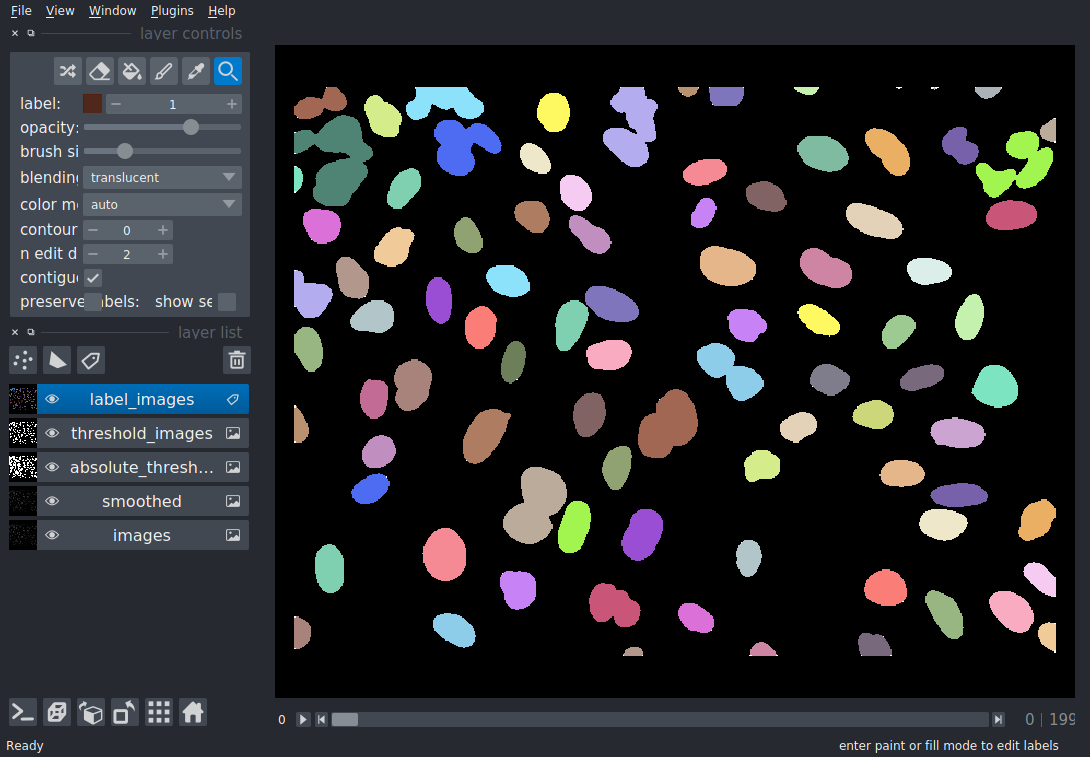

In [19]:
# Take a screenshot with napari
viewer.dims.set_point(0, 0)  # move slider back to first image frame
nbscreenshot(viewer)

In [21]:
# Measure objects in images
area = ndmeasure.area(images[:3], label_images, index)
mean_intensity = ndmeasure.mean(images[:3], label_images, index)

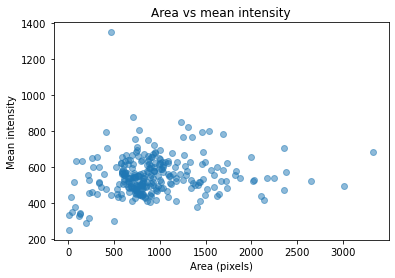

In [22]:
# Run computation and plot results
import matplotlib.pyplot as plt

plt.scatter(area, mean_intensity, alpha=0.5)
plt.gca().update(dict(title="Area vs mean intensity", xlabel='Area (pixels)', ylabel='Mean intensity'))
plt.show()

### Custom functions with Dask

What if we want to do something that isn't a function available in `dask-image`?

You can create custom functions in dask with the `map_blocks` and `map_overlsp` functions:

* [map_bocks](https://docs.dask.org/en/latest/generated/dask.array.map_blocks.html)
* [map_overlap](https://docs.dask.org/en/latest/generated/dask.array.map_overlap.html)


### Challenge

Choose a function from the [scikit-image](https://scikit-image.org/) library, and apply that to your dask array data using `map_blocks` or `map_overlap`.

Some ideas:
* Compare different filters or threshold methods found in the scikit-image [filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) moculde.
* Try blob detection using methods from the scikit-image [feature](https://scikit-image.org/docs/stable/api/skimage.feature.html) module. (Warning: this can be quite resource intensive)
* Load a sinlge TIFF image into a dask array with four chunks (in quarters). Now what happens with your custom function when you adjust the overlap number of pixels? Can you spot edge artifacts using an overlap of zero, or with `map_blocks`?


In [ ]:
# Solution